In [1]:
import numpy as np
import pylab as plt
import scipy.integrate as integrate
import math
from scipy.special import zetac, erf

# Mean Field Implementation of the Cortical Microcircuit
### Table of contents
* About this tutorial
* Mean field approximation
    * Fokker-Planck formalism
    * Parameters
    * Task 1 - Verify the equation for $K_{ij}$
    * Define neuron model
    * Define external inputs
    * Task 2 - Define connectivity (number of connections and synaptic efficacy
    * Task 3 - Perform numerical integration
    * Evaluate results
* References

## About this tutorial
The objective of this tutorial is to familiarize you with mean field approximations

## Mean field approximation
Potjans and Diesmann (2014) aggregated connectivity information of local circuits (cortical column) in early visual cortex. They subsequently used this information to simulate a network of $\sim 80000$ leaky integrate-and-fire (LIF) neurons arranged in four layers each with an excitatory and an inhibitory pool. That is quite a feat and simulation of this circuit has led to important insights. However, simulating such a system takes a very long time unless it is performed on a supercomputer. Let's see if we can simulate a mean field approximation of the column model.

<img src="Microcircuit.png"> <img src="Raster.png">

## Fokker-Planck formalism
Following Schuecker et al. (2016), the stationary firing rate $\nu_i$ of each population $i$ are given by

$\nu_i = \Phi[ \mu_i(t),\sigma_i(t)] = \{\tau_r + \tau_m \sqrt{\pi} \int_{\frac{V_{reset}-V_L-\mu_i(t)}{\sigma_i(t)} + \gamma \sqrt{\frac{\bar{\tau_s}}{\tau_m}}}^{\frac{\theta-V_L-\mu_i(t)}{\sigma_i(t)} + \gamma \sqrt{\frac{\bar{\tau_s}}{\tau_m}}} e^{x^2} (1 + erf(x))dx\}^{-1}$

where $\gamma = \frac{|\zeta(\frac{1}{2})|}{\sqrt{2}}$, with $\zeta$ denoting the Rieman zeta function and $erf(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}dt$ is the error function. The mean drive $\mu_i(t)$ as well as the diffusive noise $\sigma_i^2(t)$ depend on recurrent and external inputs:

$$\mu_i(t) = \tau_m (\sum_j \hat{K}_{ij} w_{ij} \nu_j + K_{ext} w_{ext} \nu_{ext})$$

$$\sigma_i^2(t) = \tau_m (\sum_j \hat{K}_{ij} w_{ij}^2 \nu_j + K_{ext} w_{ext}^2 \nu_{ext})$$

where $\hat{K}_{ij}$ is the average number of synapses arriving at pool $i$ from pool $j$ and $w_{ij}$ is the corresponding synaptic efficacy. Note that both $\mu$ and $\sigma$ are in units of mV.

## Parameters
Neuron model parameters are summarized in the table below

<img src="Parameters.png">

The following table contains information on the local circuit

<img src="Network.png">

The connectivity is given in terms of probabilities that a neuron in the target population receives a synapse from the source population. The equation for this probability is given by

$$P_{ij} = 1 - (1 - \frac{1}{N^j N^i})^{K_{ij}}$$

where $K_{ij}$ is the number of synapses from population $j$ to population $i$ and $N^j$ and $N^i$ are the number of pre- and postsynaptic neurons, respectively. The number of synapses is correspondingly given by

$$K_{ij} = \frac{ln(1-P_{ij})}{ln(1 - \frac{1}{N^j N^i})}$$

## Task 1 - Verify the equation for $K_{ij}$ - (33 points)

Solve $P_{ij} = 1 - (1 - \frac{1}{N^j N^i})^{K_{ij}}$ for $K_{ij}$.

\begin{equation}
P_{ij} = 1 - (1 - \frac{1}{N^j N^i})^{K_{ij}}
\end{equation}

Rearranging gives:

\begin{equation}
(1 - \frac{1}{N^j N^i})^{K_{ij}} = 1 - P_{ij}
\end{equation}

We can take the natural logarithm of both sides of the equation:

\begin{equation}
ln(1 - \frac{1}{N^j N^i})^{K_{ij}} = ln(1 - P_{ij})
\end{equation}

We also know that $ln(x^y) = y \cdot ln(x)$ therefore:

\begin{equation}
{K_{ij}} \cdot ln(1 - \frac{1}{N^j N^i}) = ln(1 - P_{ij})
\end{equation}

Finally, dividing both sides by $ln(1 - \frac{1}{N^j N^i})$ gives:

\begin{equation}
K_{ij} = \frac{ln(1-P_{ij})}{ln(1 - \frac{1}{N^j N^i})}
\end{equation}

In [2]:
# Define neuron model
J = 87.8        # synaptic strength (pA)
g = -4          # relative inhibitory synaptic strength
tau_s = 0.5e-3  # postsynaptic current time constant (s)
tau_m = 10e-3   # membrane time constant (s)
tau_r = 2e-3    # refractory period
C_m = 250       # membrane capacitance (pF)
V_reset = -65   # reset potential (mV)
V_L = -65       # leak potential (mV)
theta = -50     # threshold potential (mV)

# Define external inputs
K_ext = np.array(   # number of external connections
    [1600, 1500, 2100, 1900, 2000, 1900, 2900, 2100])

nu_ext = 8  # firing rate per connection (Hz)

## Task 2 - Define connectivity (number of connections $K$ and synaptic efficacy $W$ - 34 points)
Note that synaptic strength and synaptic efficacy are not the same. You will need to calculate $W$ bassed on other information you have. You also need to calculate the number of connections $K_{ij}$ between pools $i$ and $j$. Importantly, we are interested in the total number of connections received by pool $i$ from pool $j$, not in the number of connections received per neuron in pool $i$!

We know that the excitatory synaptic strength is:

$J = 87.8\,pA = 8.78 \cdot 10^{-11} A$

Furthermore, the membrane time constant is:

$\tau_m = 10\,ms = 0.01\,s$

The membrane capacitance is:

$C_m = 250\,pF = 2.5 \cdot 10^{-10} F$

By knowing $\tau_m$ and $C_m$ we can calculate the membrane resistance $R_m$ by this equation:

$\tau_m = R_m \cdot C_m \iff R_m = \frac{\tau_m}{C_m} \; (1)$

From Ohm's Law we have:

$W_{exc} = J \cdot R_m \; (2)$

Combining $(1)$ and $(2)$ together we can calculate $W_{exc}$ :

$W_{exc} = J \cdot \frac{\tau_m}{C_m} = 8.78 \cdot 10^{-11} A \cdot \frac{0.01\,s}{2.5 \cdot 10^{-10} F} = 0.003512\,V = 3.512\,mV$

Finally, since we know that the relative inhibitory synaptic strength $g = -4$ then:

$W_{inh} = g \cdot W_{exc} = -14.048\,mV$



In [3]:
N = np.array(    # number of neurons
    [20683, 5834, 21915, 5479, 4850, 1065, 14395, 2948])
P = np.array(   # connection probability
    [[0.101, 0.169, 0.044, 0.082, 0.032, 0.0,    0.008, 0.0],
    [0.135,  0.137, 0.032, 0.052, 0.075, 0.0,    0.004, 0.0],
    [0.008,  0.006, 0.050, 0.135, 0.007, 0.0003, 0.045, 0.0],
    [0.069,  0.003, 0.079, 0.160, 0.003, 0.0,    0.106, 0.0],
    [0.100,  0.062, 0.051, 0.006, 0.083, 0.373,  0.020, 0.0],
    [0.055,  0.027, 0.026, 0.002, 0.060, 0.316,  0.009, 0.0],
    [0.016,  0.007, 0.021, 0.017, 0.057, 0.020,  0.040, 0.225],
    [0.036,  0.001, 0.003, 0.001, 0.028, 0.008,  0.066, 0.144]])

K_hat = np.zeros((len(P), len(P)))

for i in range(len(P)):
    for j in range(len(P)):
        K_hat[i, j] = np.log(1 - P[i, j])/np.log(1 - (1/(N[i]*N[j])))

W_exc = (J*(10^(-12)))*((tau_m)/(C_m*(10^(-12))))*1000    #in mV, as calculated above
W_inh = g*W_exc                                           #in mV, as calculated above

W_ext = W_exc                        # external input (excitatory)
W_rec = np.tile([W_exc,W_inh],[8,4]) # recurrent synaptic connectivity matrix

## Task 3 - Perform numererical integration - 33 points
We can now finally find the stationary firing rates of all interacting pools by numerically integrating $\dot{\nu}_i = -\nu_i + \Phi[ \mu_i(t), \sigma_i(t) ]$. You can use the forward Euler method with a timestep $\Delta t = 0.001$ to do so. Make sure to simulate sufficiently many time steps for the system to reach equilibrium ($\sim 5000$ should do the trick). You do not need to define the activation function $\Phi$, it comes with the materials for this tutorial (phi.py).

In [4]:
#I was getting some issues with the phi function, so I did not end up using it. 
#I defined the activation function in this cell based on the phi function, while also altering some things so the integration would work.

dt = 0.001
steps = 5000

gamma = abs(zetac(0.5))/np.sqrt(2)
s_tau = np.sqrt(tau_s/tau_m)

vt = np.zeros(len(P))
vt_minus1 = np.zeros(len(P))
miu = np.zeros(len(P))
sigma_squared = np.zeros(len(P))
sigma = np.zeros(len(P))
vt_dynam = np.zeros((len(P), steps))
dV = np.zeros(len(P))
j = 0
f = np.zeros(len(P))

ran = [x*dt for x in range(0, steps)]

for k in ran:
    
    for i in range(len(P)):
        miu[i] = tau_m*(np.sum(K_hat[i,:]*W_rec[i,:]*vt_minus1[i]) + (K_ext[i]*W_ext*nu_ext))
        sigma_squared[i] = tau_m*(np.sum(K_hat[i,:]*W_rec[i,:]*W_rec[i,:]*vt_minus1[i]) + (K_ext[i]*((W_ext)**2)*nu_ext))
        sigma[i] = np.sqrt(sigma_squared[i])
    
    for n in range(len(P)):        
        lower = ((V_reset - V_L - miu[n])/sigma[n]) + gamma*s_tau
        upper = ((theta - V_L - miu[n])/sigma[n]) + gamma*s_tau
        integral, err = integrate.quad(lambda x: np.exp(x**2) * (1 + erf(x)), lower, upper)
        if math.isnan(integral) == 1:
            integral = math.inf   #if integral returns an error, then set integral to infinity
        f[n] = (tau_r + tau_m * np.sqrt(np.pi) * integral)**-1
        
    dV = -vt_minus1 + f
    vt = vt_minus1 + dV*dt
    vt_dynam[:,j] = vt
    vt_minus1 = vt
    j += 1

/tmp/ipykernel_19864/946251522.py:32: RuntimeWarning: overflow encountered in exp
  integral, err = integrate.quad(lambda x: np.exp(x**2) * (1 + erf(x)), lower, upper)
/tmp/ipykernel_19864/946251522.py:32: RuntimeWarning: invalid value encountered in double_scalars
  integral, err = integrate.quad(lambda x: np.exp(x**2) * (1 + erf(x)), lower, upper)
/tmp/ipykernel_19864/946251522.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, err = integrate.quad(lambda x: np.exp(x**2) * (1 + erf(x)), lower, upper)
/tmp/ipykernel_19864/946251522.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

## Evaluate results
As a last step, we need to check if the mean firing rates we obtained using the mean field approximation look anything like the results Potjans & Diesmann (2014) obtained when simulating their full model. Assuming that you called the firing rate variable keeping track of the firing rates $\nu$ and that pools are along its rows and time along its columns, the following code plots bar graphs showing the firing rate in all pools.

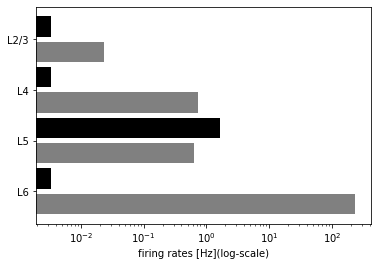

In [5]:
#It should be mentioned that the firing rates are plotted in a logarithmic scale.
plt.figure()
plt.barh(y = [7,6,5,4,3,2,1,0], width= vt_dynam[:,steps-1], color = ["black", "grey", "black", "grey", "black", "grey", "black", "grey"], log = 1)
plt.yticks([6.5, 4.5, 2.5, 0.5], labels=['L2/3', 'L4', 'L5', 'L6'])
plt.xlabel("firing rates [Hz](log-scale)")
plt.show()

Compare this to the mean firing rates observed by Potjans & Diesmann (2014)

<img src="Rates.png">

## References
* Potjans TC, Diesmann M. The cell-type specific cortical microcircuit: relating structure and activity in a full-scale spiking network model. Cereb Cortex. 2014 Mar;24(3):785-806. doi: 10.1093/cercor/bhs358. Epub 2012 Dec 2. PMID: 23203991; PMCID: PMC3920768
* Schuecker, J., Schmidt, M., van Albada, S. J., Diesmann, M., & Helias, M. (2017). Fundamental Activity Constraints Lead to Specific Interpretations of the Connectome. PLOS Computational Biology, 13(2), e1005179. https://doi.org/10.1371/journal.pcbi.1005179